In [48]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata
from scipy.ndimage import laplace
import h5py
import torchinfo
from torchvision.transforms import Resize, InterpolationMode
from skimage.metrics import structural_similarity as compute_ssim_skimage
from skimage.metrics import peak_signal_noise_ratio as compute_psnr_skimage
from tqdm import tqdm


In [49]:
random.seed(1729)

# Set up device for model training
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if hasattr(torch, 'mps') and torch.mps.is_available() else
                      "cpu")
print(f"Using device: {device}")

Using device: cuda


## Prepare Data


In [50]:
DATA_PATH = "/mnt/c/train/nskt_Re16000.h5"

In [51]:
HDF5_KEY = 'fields'
SCALE_FACTOR = 4

HR_PATCH_SIZE = 256
LR_PATCH_SIZE = HR_PATCH_SIZE // SCALE_FACTOR # Will be 64

BRANCH_TRUNK_DIM = 128
NUM_OUTPUT_CHANNELS = 3      # u, v, vorticity

BATCH_SIZE = 128

# Training Hyperparameters
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200              # Adjust as needed
TEST_SPLIT_RATIO = 0.2       # Using 20% test split
GRAD_CLIP_VALUE = 1.0        # Gradient clipping value
SCHEDULER_STEP_SIZE = 20     # Reduce LR every N epochs
SCHEDULER_GAMMA = 0.25        # Factor to reduce LR by
NUM_WORKERS = 4              # Set to 0 if issues

FOURIER_MAPPING_SIZE = 256 # Dimension of the Fourier features (output is 2*mapping_size)
FOURIER_SCALE = 10.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
def calculate_psnr(hr_true, hr_pred):
    hr_true = np.asarray(hr_true)
    hr_pred = np.asarray(hr_pred)
    data_range = hr_true.max() - hr_true.min()
    if data_range == 0: return float('inf')
    # Ensure positive data range if min == max
    data_range = max(data_range, 1e-6)
    try:
        return compute_psnr_skimage(hr_true, hr_pred, data_range=data_range)
    except ValueError as e:
        print(f"PSNR Error: {e}, shapes: {hr_true.shape}, {hr_pred.shape}")
        return 0.0


def calculate_ssim(hr_true, hr_pred):
    hr_true = np.asarray(hr_true)
    hr_pred = np.asarray(hr_pred)
    data_range = hr_true.max() - hr_true.min()
    if data_range == 0: return 1.0 if np.all(hr_true == hr_pred) else 0.0
    data_range = max(data_range, 1e-6) # Ensure positive range

    # Need channel_axis for multi-channel data
    if hr_true.ndim == 3 and hr_true.shape[0] == NUM_OUTPUT_CHANNELS: # Check if channels-first
         hr_true_sk = np.transpose(hr_true, (1, 2, 0)) # H, W, C
         hr_pred_sk = np.transpose(hr_pred, (1, 2, 0)) # H, W, C
         win_size = min(7, hr_true_sk.shape[0], hr_true_sk.shape[1])
         if win_size < 2: return 0.0 # Window too small
         if win_size % 2 == 0: win_size -=1
         try:
              # Use channel_axis=-1 because we transposed to HWC
              return compute_ssim_skimage(hr_true_sk, hr_pred_sk, data_range=data_range, channel_axis=-1, win_size=win_size)
         except ValueError as e:
              print(f"SSIM Error: {e}, shapes: {hr_true_sk.shape}, {hr_pred_sk.shape}, win_size: {win_size}")
              return 0.0
    else: # Assume grayscale or unexpected format
        print(f"Warning: Unexpected shape for SSIM: {hr_true.shape}")
        return 0.0

In [53]:
class NSKTSuperResDataset(Dataset):
    def __init__(self, hdf5_path, hdf5_key, indices, scale_factor, hr_patch_size, train_mean=None, train_std=None):
        self.hdf5_path = hdf5_path
        self.hdf5_key = hdf5_key
        self.indices = indices
        self.scale_factor = scale_factor
        self.hr_patch_size = hr_patch_size
        self.lr_patch_size = hr_patch_size // scale_factor
        self._data_handle = None

        # Store normalization stats (should be tensors)
        self.mean = train_mean
        self.std = train_std
        if self.std is not None:
            # Prevent division by zero if std dev is zero for a channel
             self.std = torch.clamp(self.std, min=1e-6)

        self.hr_coords = self._generate_relative_coords(self.hr_patch_size)

    def _get_data_handle(self):
        if self._data_handle is None:
            try:
                self._data_handle = h5py.File(self.hdf5_path, 'r')
            except Exception as e:
                print(f"Error opening HDF5 file {self.hdf5_path}: {e}")
                raise
        return self._data_handle[self.hdf5_key]

    def _generate_relative_coords(self, size):
        y = torch.linspace(0, 1, size)
        x = torch.linspace(0, 1, size)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        coords = torch.stack((grid_y, grid_x), dim=-1)
        return coords

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data_idx = self.indices[idx]
        try:
            data_handle = self._get_data_handle()
            hr_sample = torch.from_numpy(data_handle[data_idx, :, :, :].astype(np.float32))
        except Exception as e:
            print(f"Error reading index {data_idx} from {self.hdf5_path}: {e}")
            # Return dummy data
            return {'lr': torch.zeros((NUM_OUTPUT_CHANNELS, self.lr_patch_size, self.lr_patch_size)),
                    'hr': torch.zeros((NUM_OUTPUT_CHANNELS, self.hr_patch_size, self.hr_patch_size)),
                    'coords': self.hr_coords}

        # Random Cropping
        c, h, w = hr_sample.shape
        if h < self.hr_patch_size or w < self.hr_patch_size:
            # Handle small samples - e.g., resize (might distort data) or skip
            # Resizing up just to crop doesn't make sense. Let's just skip for now by returning zeros.
            print(f"Warning: Sample {data_idx} ({h}x{w}) smaller than HR patch size ({self.hr_patch_size}). Returning zeros.")
            return {'lr': torch.zeros((NUM_OUTPUT_CHANNELS, self.lr_patch_size, self.lr_patch_size)),
                    'hr': torch.zeros((NUM_OUTPUT_CHANNELS, self.hr_patch_size, self.hr_patch_size)),
                    'coords': self.hr_coords}
        hr_top = random.randint(0, h - self.hr_patch_size)
        hr_left = random.randint(0, w - self.hr_patch_size)
        hr_patch = hr_sample[:, hr_top:hr_top+self.hr_patch_size, hr_left:hr_left+self.hr_patch_size]

        # Bicubic Downsampling
        lr_patch = Resize((self.lr_patch_size, self.lr_patch_size),
                          interpolation=InterpolationMode.BICUBIC,
                          antialias=True)(hr_patch)

        # Apply Normalization (if stats are provided)
        hr_patch_norm = hr_patch # Default if no stats
        lr_patch_norm = lr_patch # Default if no stats
        if self.mean is not None and self.std is not None:
            hr_patch_norm = (hr_patch - self.mean[:, None, None]) / self.std[:, None, None]
            lr_patch_norm = (lr_patch - self.mean[:, None, None]) / self.std[:, None, None]

        return {'lr': lr_patch_norm, 'hr': hr_patch_norm, 'coords': self.hr_coords}

    def close(self):
        if self._data_handle is not None: self._data_handle.file.close(); self._data_handle = None


In [54]:
class BranchNet(nn.Module):
    """Simple CNN Branch Net - Adjusted for potentially larger LR patch size if needed"""
    def __init__(self, output_dim):
        super(BranchNet, self).__init__()
        # Input: (Batch, 3, 32, 32) for HR=128, scale=4
        self.conv1 = nn.Conv2d(NUM_OUTPUT_CHANNELS, 32, kernel_size=5, stride=2, padding=2) # 64->32
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # 32->16
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # 16->8
        self.relu3 = nn.ReLU()
        # Add another conv layer if needed, e.g., to get to 2x2 or 1x1
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1) # 4->2
        self.relu4 = nn.ReLU()
        self.flatten = nn.Flatten()

        # Calculate flattened size dynamically (4 conv layers with stride 2)
        final_conv_size = LR_PATCH_SIZE // (2**4) # 64 // 16 = 4
        if final_conv_size <= 0: raise ValueError("LR Patch Size too small for 3 conv layers")
        # Using 128 channels from conv3
        self.fc1_input_dim = 256 * final_conv_size * final_conv_size # 128 * 8 * 8 = 8192

        self.fc1 = nn.Linear(self.fc1_input_dim, 256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, output_dim) # Output dim p

    def forward(self, x_lr):
        x = self.relu1(self.conv1(x_lr))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# --- >>> NEW Fourier Embedding Layer <<< ---
class FourierEmbedding(nn.Module):
    """Gaussian Fourier Feature Mapping."""
    def __init__(self, input_dim, mapping_size=256, scale=10.0):
        super().__init__()
        # Cannot register buffer in __init__ before super().__init__() if used
        # Instead, create parameter/buffer after super call or handle device placement manually
        # Using Parameter makes it part of model.parameters(), Buffer does not. Use Buffer.
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        # Make B a buffer so it's part of the state_dict but not trained
        self.register_buffer('B', torch.randn(input_dim, mapping_size) * scale)

    def forward(self, x):
        # x shape: (..., input_dim)
        # B shape: (input_dim, mapping_size)
        # Ensure B is on the same device as x
        B_device = self.B.to(x.device)
        x_proj = (2. * torch.pi * x) @ B_device # Shape: (..., mapping_size)
        # Output shape: (..., 2 * mapping_size)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class TrunkNet(nn.Module):
    """MLP Trunk Net with Fourier Embedding for Input Coordinates."""
    def __init__(self, output_dim, num_output_channels, fourier_mapping_size):
        super(TrunkNet, self).__init__()
        self.num_output_channels = num_output_channels
        self.output_dim_per_channel = output_dim

        # Fourier Embedding for 2D coordinates
        self.fourier_embed = FourierEmbedding(input_dim=2, mapping_size=fourier_mapping_size, scale=FOURIER_SCALE)
        fourier_output_dim = 2 * fourier_mapping_size # sin and cos

        # MLP layers operate on the Fourier features
        self.fc1 = nn.Linear(fourier_output_dim, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        # Final layer outputs p * C features per location
        self.fc3 = nn.Linear(256, self.output_dim_per_channel * self.num_output_channels)

        # Cache for embedded coordinates
        self.cached_embedded_coords = None
        self.cached_coords_shape = None

    def forward(self, coords_hr):
        # coords_hr expected shape: (hr_patch_size, hr_patch_size, 2)
        # num_pixels = coords_hr.size(0) * coords_hr.size(1)
        # coords_flat = coords_hr.view(num_pixels, 2) # Flatten to (hr_pixels, 2)

        # # Apply Fourier Embedding
        # embedded_coords = self.fourier_embed(coords_flat) # Shape: (hr_pixels, 2 * fourier_mapping_size)

        # # Process with MLP
        # x = self.relu1(self.fc1(embedded_coords))
        # x = self.relu2(self.fc2(x))
        # x = self.fc3(x)


        num_pixels = coords_hr.size(0) * coords_hr.size(1)
        current_shape = (coords_hr.size(0), coords_hr.size(1))
        
        # Only recompute embeddings if coords shape changed
        if self.cached_embedded_coords is None or self.cached_coords_shape != current_shape:
            coords_flat = coords_hr.view(num_pixels, 2) # Flatten to (hr_pixels, 2)
            self.cached_embedded_coords = self.fourier_embed(coords_flat)
            self.cached_coords_shape = current_shape
        
        # Ensure cached_embedded_coords is on the same device as coords_hr
        embedded_coords = self.cached_embedded_coords.to(coords_hr.device)

        # Process with MLP using cached embeddings
        x = self.relu1(self.fc1(embedded_coords))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        # Output shape: (hr_pixels, p * num_channels)
        return x

class DeepONetSR(nn.Module):
    """DeepONet SR with Fourier Embedding Trunk."""
    def __init__(self, branch_trunk_dim, num_output_channels, fourier_mapping_size):
        super(DeepONetSR, self).__init__()
        self.branch_net = BranchNet(branch_trunk_dim)
        # Pass fourier mapping size to TrunkNet
        self.trunk_net = TrunkNet(branch_trunk_dim, num_output_channels, fourier_mapping_size)
        self.num_output_channels = num_output_channels
        self.branch_trunk_dim = branch_trunk_dim

    def forward(self, x_lr, coords_hr):
        branch_out = self.branch_net(x_lr)           # (Batch, p)
        trunk_out = self.trunk_net(coords_hr)        # (hr_pixels, p * C)
        
        hr_pixels = trunk_out.size(0); p = self.branch_trunk_dim
        C = self.num_output_channels; batch_s = x_lr.size(0)
        hr_h = coords_hr.size(0); hr_w = coords_hr.size(1)
        
        # More efficient matrix operations using einsum
        # Reshape trunk_out to (hr_pixels, C, p)
        trunk_reshaped = trunk_out.view(hr_pixels, C, p)
        
        # Use einsum for a more efficient batch matrix multiplication
        # 'bp,hcp->bhc' means: batch x params @ height*width x channels x params -> batch x height*width x channels
        output = torch.einsum('bp,hcp->bhc', branch_out, trunk_reshaped)
        
        # Reshape to standard image format: (Batch, C, H, W)
        return output.permute(0, 2, 1).reshape(batch_s, C, hr_h, hr_w)

In [55]:
def train_epoch(model, loader, optimizer, criterion, device, coords_hr_template, grad_clip_value):
    model.train(); running_loss = 0.0
    coords_hr_template = coords_hr_template.to(device)
    pbar = tqdm(loader, desc="Training", leave=False)
    for batch in pbar:
        lr_patches = batch['lr'].to(device); hr_patches = batch['hr'].to(device)
        optimizer.zero_grad()
        outputs = model(lr_patches, coords_hr_template)
        loss = criterion(outputs, hr_patches)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)
        optimizer.step()
        running_loss += loss.item(); pbar.set_postfix(loss=loss.item())
    return running_loss / len(loader)

In [56]:
def evaluate_epoch(model, loader, criterion, device, coords_hr_template, train_mean, train_std):
    model.eval(); running_loss = 0.0; total_psnr = 0.0; total_ssim = 0.0; num_samples = 0
    coords_hr_template = coords_hr_template.to(device)
    mean_cpu = train_mean.cpu(); std_cpu = train_std.cpu() # CPU for numpy conversion
    pbar = tqdm(loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in pbar:
            lr_patches = batch['lr'].to(device); hr_patches_norm = batch['hr'].to(device)
            outputs_norm = model(lr_patches, coords_hr_template)
            loss = criterion(outputs_norm, hr_patches_norm)
            running_loss += loss.item() * lr_patches.size(0)
            # Denormalize
            outputs_denorm = outputs_norm.cpu() * std_cpu[None, :, None, None] + mean_cpu[None, :, None, None]
            hr_patches_denorm = hr_patches_norm.cpu() * std_cpu[None, :, None, None] + mean_cpu[None, :, None, None]
            # Metrics per sample
            for i in range(outputs_denorm.size(0)):
                 pred = outputs_denorm[i].numpy(); gt = hr_patches_denorm[i].numpy()
                 total_psnr += calculate_psnr(gt, pred)
                 total_ssim += calculate_ssim(gt, pred) # Assumes C,H,W
                 num_samples += 1
    if num_samples == 0: return 0.0, 0.0, 0.0 # Avoid division by zero
    return running_loss / num_samples, total_psnr / num_samples, total_ssim / num_samples

In [57]:
def visualize_sample(model, dataset, device, title="SR Result", train_mean=None, train_std=None):
    model.eval(); sample_idx = random.randint(0, len(dataset) - 1); sample = dataset[sample_idx]
    lr_patch_norm = sample['lr'].unsqueeze(0).to(device); hr_gt_patch_norm = sample['hr']
    coords_hr = sample['coords'].to(device)
    with torch.no_grad(): hr_pred_patch_norm = model(lr_patch_norm, coords_hr).squeeze(0).cpu()
    # Denormalize
    hr_gt_patch = hr_gt_patch_norm; hr_pred_patch = hr_pred_patch_norm
    if train_mean is not None and train_std is not None:
        mean_cpu = train_mean.cpu(); std_cpu = train_std.cpu()
        hr_gt_patch = hr_gt_patch_norm * std_cpu[:, None, None] + mean_cpu[:, None, None]
        hr_pred_patch = hr_pred_patch_norm * std_cpu[:, None, None] + mean_cpu[:, None, None]
    # Plotting
    channel_to_plot = 2
    hr_gt_np = hr_gt_patch.permute(1, 2, 0).numpy()[:, :, channel_to_plot]
    hr_pred_np = hr_pred_patch.permute(1, 2, 0).numpy()[:, :, channel_to_plot]
    psnr_sample = calculate_psnr(hr_gt_np, hr_pred_np)
    ssim_sample = calculate_ssim(hr_gt_patch.numpy(), hr_pred_patch.numpy())
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{title} (Ch {channel_to_plot}) | PSNR: {psnr_sample:.2f} | SSIM: {ssim_sample:.3f}')
    # LR
    lr_rescaled = Resize((HR_PATCH_SIZE, HR_PATCH_SIZE), interpolation=InterpolationMode.NEAREST)(sample['lr'])
    axes[0].imshow(lr_rescaled.permute(1, 2, 0).numpy()[:, :, channel_to_plot], cmap='viridis'); axes[0].set_title(f'Low-Res ({LR_PATCH_SIZE}x{LR_PATCH_SIZE})'); axes[0].axis('off')
    # GT / Pred
    vmin = min(hr_gt_np.min(), hr_pred_np.min()); vmax = max(hr_gt_np.max(), hr_pred_np.max())
    im1 = axes[1].imshow(hr_gt_np, cmap='viridis', vmin=vmin, vmax=vmax); axes[1].set_title(f'Ground Truth ({HR_PATCH_SIZE}x{HR_PATCH_SIZE})'); axes[1].axis('off')
    im2 = axes[2].imshow(hr_pred_np, cmap='viridis', vmin=vmin, vmax=vmax); axes[2].set_title('Prediction'); axes[2].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04); fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


In [58]:
# Physics-Based Loss Functions
def compute_divergence_2d(velocity_field):
    """
    Compute the divergence of a 2D velocity field using central differences.
    Input shape: (B, 2, H, W) where channels 0 and 1 are u and v components
    Output shape: (B, H, W)
    """
    # Extract u and v velocity components
    u = velocity_field[:, 0, :, :]  # (B, H, W)
    v = velocity_field[:, 1, :, :]  # (B, H, W)
    
    batch_size, height, width = u.shape
    
    # Compute gradient of u with respect to x (horizontal)
    du_dx = torch.zeros_like(u)
    # Central difference for interior points
    du_dx[:, :, 1:-1] = (u[:, :, 2:] - u[:, :, :-2]) / 2.0
    # Forward/backward differences for boundaries
    du_dx[:, :, 0] = u[:, :, 1] - u[:, :, 0]
    du_dx[:, :, -1] = u[:, :, -1] - u[:, :, -2]
    
    # Compute gradient of v with respect to y (vertical)
    dv_dy = torch.zeros_like(v)
    # Central difference for interior points
    dv_dy[:, 1:-1, :] = (v[:, 2:, :] - v[:, :-2, :]) / 2.0
    # Forward/backward differences for boundaries
    dv_dy[:, 0, :] = v[:, 1, :] - v[:, 0, :]
    dv_dy[:, -1, :] = v[:, -1, :] - v[:, -2, :]
    
    # Divergence = du/dx + dv/dy
    divergence = du_dx + dv_dy
    return divergence

def compute_vorticity_2d(velocity_field):
    """
    Compute the vorticity (curl) of a 2D velocity field using central differences.
    Input shape: (B, 2, H, W) where channels 0 and 1 are u and v components
    Output shape: (B, H, W)
    """
    # Extract u and v velocity components
    u = velocity_field[:, 0, :, :]  # (B, H, W)
    v = velocity_field[:, 1, :, :]  # (B, H, W)
    
    batch_size, height, width = u.shape
    
    # Compute gradient of v with respect to x (horizontal)
    dv_dx = torch.zeros_like(v)
    # Central difference for interior points
    dv_dx[:, :, 1:-1] = (v[:, :, 2:] - v[:, :, :-2]) / 2.0
    # Forward/backward differences for boundaries
    dv_dx[:, :, 0] = v[:, :, 1] - v[:, :, 0]
    dv_dx[:, :, -1] = v[:, :, -1] - v[:, :, -2]
    
    # Compute gradient of u with respect to y (vertical)
    du_dy = torch.zeros_like(u)
    # Central difference for interior points
    du_dy[:, 1:-1, :] = (u[:, 2:, :] - u[:, :-2, :]) / 2.0
    # Forward/backward differences for boundaries
    du_dy[:, 0, :] = u[:, 1, :] - u[:, 0, :]
    du_dy[:, -1, :] = u[:, -1, :] - u[:, -2, :]
    
    # Vorticity (curl in 2D) = dv/dx - du/dy
    vorticity = dv_dx - du_dy
    return vorticity

class PhysicsInformedLoss(nn.Module):
    """Combined loss function with data fitting and physics constraints"""
    def __init__(self, mse_weight=1.0, div_weight=0.1, vort_weight=0.1):
        super(PhysicsInformedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.mse_weight = mse_weight
        self.div_weight = div_weight
        self.vort_weight = vort_weight

    def forward(self, pred, target):
        # Data fitting loss (MSE)
        mse_loss = self.mse_loss(pred, target)
        
        # Physics-based losses
        # Calculate divergence - for incompressible flow, should be zero
        if self.div_weight > 0:
            # Extract velocity components (first two channels)
            pred_velocity = pred[:, :2, :, :]
            divergence = compute_divergence_2d(pred_velocity)
            div_loss = torch.mean(divergence**2)  # L2 norm of divergence
        else:
            div_loss = torch.tensor(0.0, device=pred.device)
        
        # Vorticity consistency loss (optional)
        if self.vort_weight > 0:
            # If we have vorticity as the third channel
            if pred.shape[1] >= 3:
                pred_velocity = pred[:, :2, :, :]
                pred_vorticity = pred[:, 2, :, :]  # Predicted vorticity
                computed_vorticity = compute_vorticity_2d(pred_velocity)
                # Vorticity should match the computed curl of velocity
                vort_loss = torch.mean((pred_vorticity - computed_vorticity)**2)
            else:
                vort_loss = torch.tensor(0.0, device=pred.device)
        else:
            vort_loss = torch.tensor(0.0, device=pred.device)

        # Combined loss
        total_loss = (self.mse_weight * mse_loss + 
                      self.div_weight * div_loss + 
                      self.vort_weight * vort_loss)

        return total_loss

In [ ]:
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"HR Patch Size: {HR_PATCH_SIZE}x{HR_PATCH_SIZE}, LR Patch Size: {LR_PATCH_SIZE}x{LR_PATCH_SIZE}")
    print(f"Batch Size: {BATCH_SIZE}")

    # 1. Load Data Indices and Split
    try:
        with h5py.File(DATA_PATH, 'r') as f: num_samples = f[HDF5_KEY].shape[0]
        print(f"Found {num_samples} samples."); indices = np.arange(num_samples)
        split_idx = int(num_samples * (1.0 - TEST_SPLIT_RATIO))
        train_indices = indices[:split_idx]; test_indices = indices[split_idx:]
        print(f"Train: {len(train_indices)}, Test: {len(test_indices)}")
        if len(test_indices) == 0: raise ValueError("Test set has 0 samples.")
    except Exception as e: print(f"Index/Split Error: {e}"); sys.exit(1)

    # 2. Calculate Normalization Stats
    print("Calculating normalization stats...")
    try:
        stats_dataset = NSKTSuperResDataset(DATA_PATH, HDF5_KEY, train_indices, SCALE_FACTOR, HR_PATCH_SIZE)
        stats_loader = DataLoader(stats_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        mean_sum = torch.zeros(NUM_OUTPUT_CHANNELS); std_sum_sq = torch.zeros(NUM_OUTPUT_CHANNELS); num_pixels_total = 0
        # Mean Pass
        for batch in tqdm(stats_loader, desc="Calc Mean"):
            hr_data = batch['hr']; batch_pixels = hr_data.size(0) * hr_data.size(2) * hr_data.size(3)
            mean_sum += hr_data.sum(dim=(0, 2, 3)); num_pixels_total += batch_pixels
        train_mean = mean_sum / num_pixels_total
        # Std Dev Pass
        for batch in tqdm(stats_loader, desc="Calc Std Dev"):
             hr_data = batch['hr']
             std_sum_sq += ((hr_data - train_mean[None, :, None, None])**2).sum(dim=(0, 2, 3))
        train_std = torch.sqrt(std_sum_sq / num_pixels_total)
        stats_dataset.close()
        print(f"Mean: {train_mean.numpy()}, Std: {train_std.numpy()}")
    except Exception as e:
        print(f"\nStats Calc Error: {e}. Using mean=0, std=1."); train_mean = torch.zeros(NUM_OUTPUT_CHANNELS); train_std = torch.ones(NUM_OUTPUT_CHANNELS)
        if 'stats_dataset' in locals(): stats_dataset.close() # Ensure file is closed

    # 3. Create Datasets and DataLoaders
    print("Creating datasets...")
    try:
        train_dataset = NSKTSuperResDataset(DATA_PATH, HDF5_KEY, train_indices, SCALE_FACTOR, HR_PATCH_SIZE, train_mean, train_std)
        test_dataset = NSKTSuperResDataset(DATA_PATH, HDF5_KEY, test_indices, SCALE_FACTOR, HR_PATCH_SIZE, train_mean, train_std)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
        coords_template = train_dataset.hr_coords
    except Exception as e:
        print(f"DataLoader Error: {e}")
        if 'train_dataset' in locals(): train_dataset.close()
        if 'test_dataset' in locals(): test_dataset.close()
        sys.exit(1)

    # 4. Initialize Model, Loss, Optimizer, Scheduler
    print("Initializing model...")
    model = DeepONetSR(branch_trunk_dim=BRANCH_TRUNK_DIM,
                       num_output_channels=NUM_OUTPUT_CHANNELS,
                       fourier_mapping_size=FOURIER_MAPPING_SIZE).to(DEVICE) # Pass fourier size
    criterion = PhysicsInformedLoss(mse_weight=1.0, div_weight=0.5, vort_weight=0.5)
    
    # Print model summary
    print("\nModel Summary:")
    torchinfo.summary(model)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=SCHEDULER_GAMMA)

    # 5. Training Loop
    print("Starting training...")
    train_losses, test_losses, test_psnrs, test_ssims = [], [], [], []
    for epoch in range(NUM_EPOCHS):
        
        train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE, coords_template, GRAD_CLIP_VALUE)
        test_loss, test_psnr, test_ssim = evaluate_epoch(model, test_loader, criterion, DEVICE, coords_template, train_mean, train_std)
        scheduler.step()
        # Store history
        train_losses.append(train_loss); test_losses.append(test_loss); test_psnrs.append(test_psnr); test_ssims.append(test_ssim)
        
        # Print epoch results
        if (epoch+1) % 10 == 0 or epoch == NUM_EPOCHS - 1:
            print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | Test PSNR: {test_psnr:.3f} | Test SSIM: {test_ssim:.4f} | LR: {scheduler.get_last_lr()[0]:.1e}")

    # Close HDF5 file handles
    train_dataset.close(); test_dataset.close()
    print("\nTraining finished.")


Using device: cuda
HR Patch Size: 256x256, LR Patch Size: 64x64
Batch Size: 128
Found 1000 samples.
Train: 800, Test: 200
Calculating normalization stats...


Calc Std Dev: 100%|██████████| 7/7 [02:22<00:00, 20.38s/it]


Mean: [-0.02575364  0.00442933 -0.09271314], Std: [0.67933226 0.6622604  9.52083   ]
Creating datasets...
Initializing model...

Model Summary:
Starting training...



--- Epoch 10/200 ---
Epoch [10/200] | Train Loss: 0.544156 | Test Loss: 0.487573 | Test PSNR: 23.353 | Test SSIM: 0.6372 | LR: 1.0e-03



--- Epoch 20/200 ---
Epoch [20/200] | Train Loss: 0.395067 | Test Loss: 0.383606 | Test PSNR: 23.809 | Test SSIM: 0.6902 | LR: 2.5e-04



--- Epoch 30/200 ---
Epoch [30/200] | Train Loss: 0.373471 | Test Loss: 0.362139 | Test PSNR: 24.096 | Test SSIM: 0.7037 | LR: 2.5e-04



--- Epoch 40/200 ---
Epoch [40/200] | Train Loss: 0.346900 | Test Loss: 0.332046 | Test PSNR: 24.022 | Test SSIM: 0.7111 | LR: 6.3e-05



--- Epoch 50/200 ---
Epoch [50/200] | Train Loss: 0.333165 | Test Loss: 0.325773 | Test PSNR: 24.327 | Test SSIM: 0.7193 | LR: 6.3e-05



--- Epoch 60/200 ---
Epoch [60/200] | Train Loss: 0.323927 | Test Loss: 0.323521 | Test PSNR: 24.271 | Test SSIM: 0.7196 | LR: 1.6e-05



--- Epoch 70/200 ---
Epoch [70/200] | Train Loss: 0.329040 | Test Loss: 0.318896 | Test PSNR: 24.237 | Test SSIM: 0.7196 | LR: 1.6e-05



--- Epoch 80/200 ---
Epoch [80/200] | Train Loss: 0.318579 | Test Loss: 0.309150 | Test PSNR: 24.401 | Test SSIM: 0.7222 | LR: 3.9e-06



--- Epoch 90/200 ---
Epoch [90/200] | Train Loss: 0.322617 | Test Loss: 0.317243 | Test PSNR: 24.322 | Test SSIM: 0.7197 | LR: 3.9e-06



--- Epoch 100/200 ---
Epoch [100/200] | Train Loss: 0.328288 | Test Loss: 0.318347 | Test PSNR: 24.291 | Test SSIM: 0.7216 | LR: 9.8e-07



--- Epoch 110/200 ---
Epoch [110/200] | Train Loss: 0.324434 | Test Loss: 0.315795 | Test PSNR: 24.241 | Test SSIM: 0.7195 | LR: 9.8e-07



--- Epoch 120/200 ---
Epoch [120/200] | Train Loss: 0.325031 | Test Loss: 0.312000 | Test PSNR: 24.303 | Test SSIM: 0.7205 | LR: 2.4e-07



--- Epoch 130/200 ---
Epoch [130/200] | Train Loss: 0.321454 | Test Loss: 0.313612 | Test PSNR: 24.244 | Test SSIM: 0.7186 | LR: 2.4e-07



--- Epoch 140/200 ---
Epoch [140/200] | Train Loss: 0.319897 | Test Loss: 0.303418 | Test PSNR: 24.294 | Test SSIM: 0.7209 | LR: 6.1e-08



--- Epoch 150/200 ---
Epoch [150/200] | Train Loss: 0.318769 | Test Loss: 0.314946 | Test PSNR: 24.461 | Test SSIM: 0.7219 | LR: 6.1e-08



--- Epoch 160/200 ---
Epoch [160/200] | Train Loss: 0.318811 | Test Loss: 0.306824 | Test PSNR: 24.293 | Test SSIM: 0.7187 | LR: 1.5e-08



--- Epoch 170/200 ---
Epoch [170/200] | Train Loss: 0.333929 | Test Loss: 0.311824 | Test PSNR: 24.336 | Test SSIM: 0.7211 | LR: 1.5e-08



--- Epoch 180/200 ---
Epoch [180/200] | Train Loss: 0.320821 | Test Loss: 0.322018 | Test PSNR: 24.450 | Test SSIM: 0.7227 | LR: 3.8e-09


Training:   0%|          | 0/7 [00:00<?, ?it/s]                    

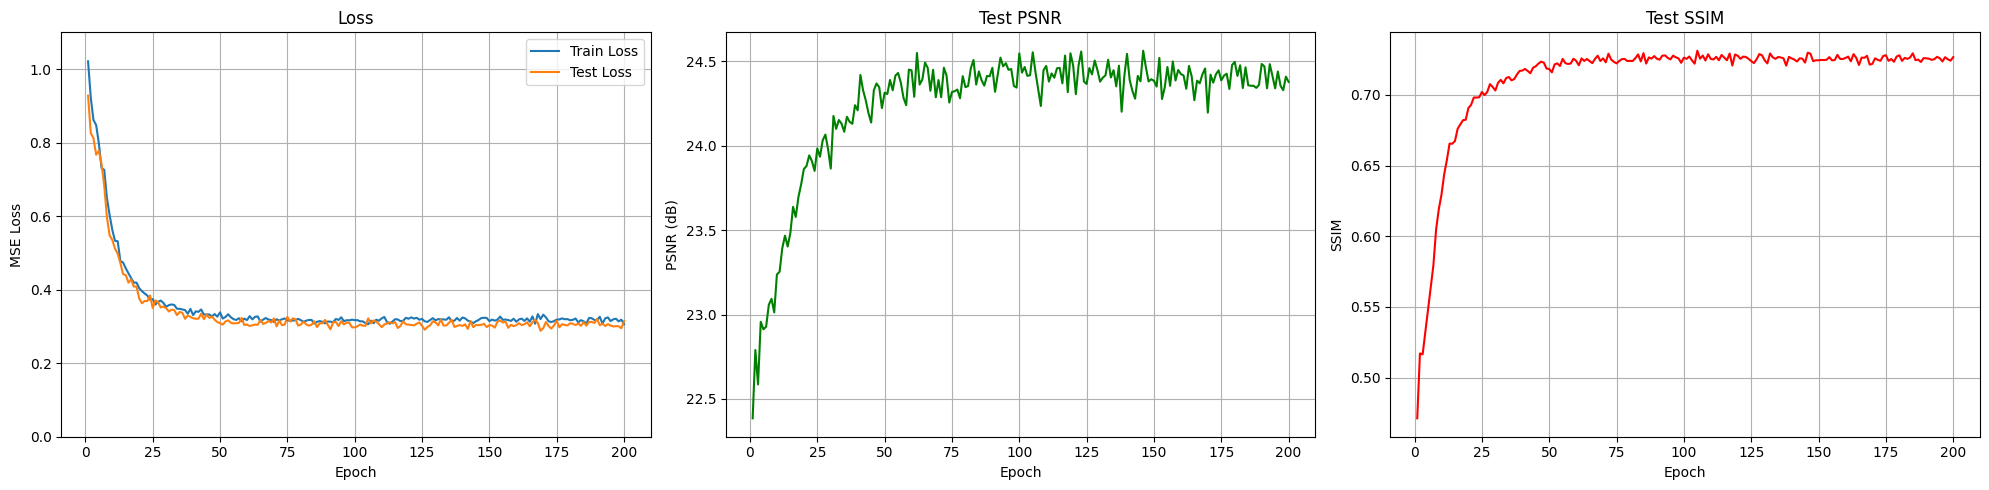


Visualizing a random test sample...


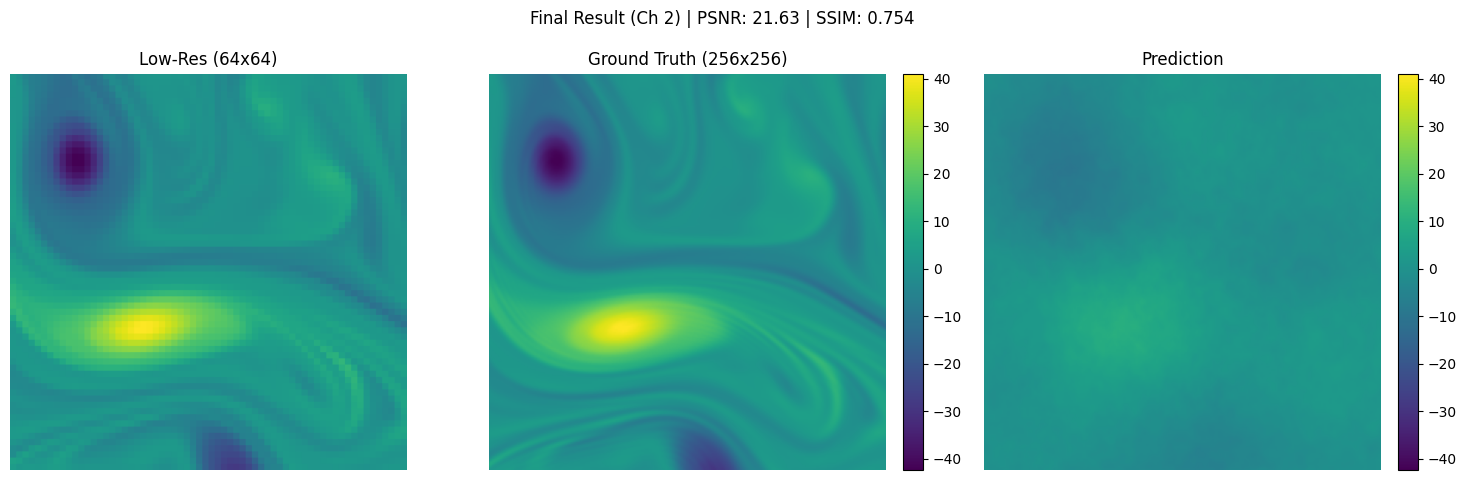


Visualizing a random test sample...


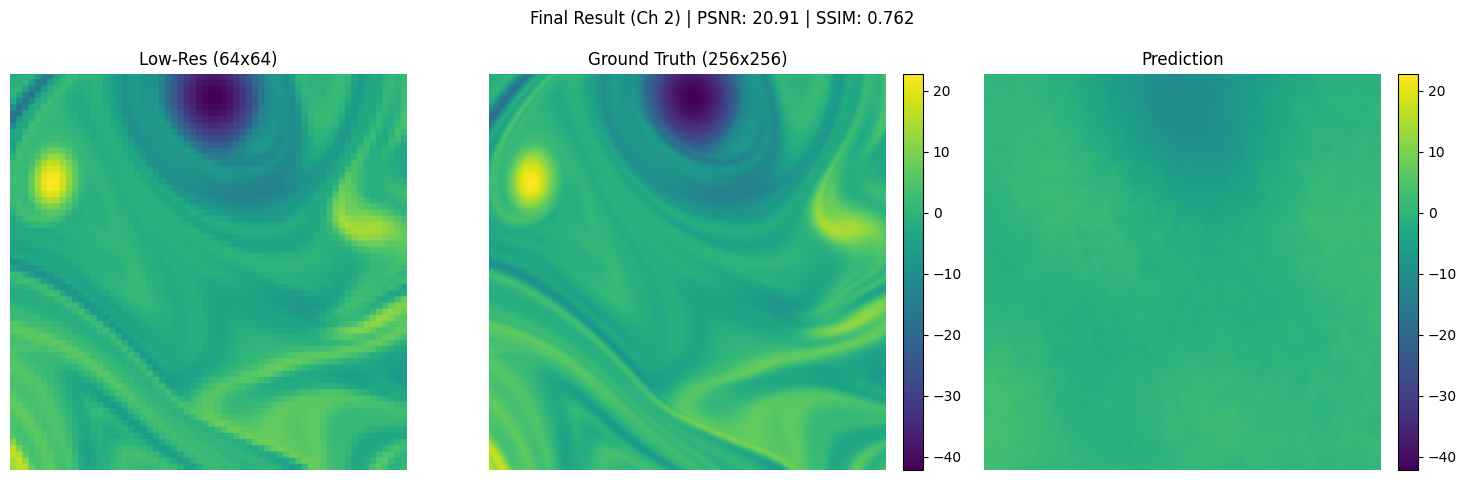

In [ ]:

    # 6. Plot Losses & Metrics (Same as before)
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs[0].plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss'); axs[0].plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss'); axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('MSE Loss'); axs[0].set_title('Loss'); axs[0].legend(); axs[0].set_ylim(0, 1.1); axs[0].grid(True)
    axs[1].plot(range(1, NUM_EPOCHS + 1), test_psnrs, label='Test PSNR', color='g'); axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('PSNR (dB)'); axs[1].set_title('Test PSNR'); axs[1].grid(True)
    axs[2].plot(range(1, NUM_EPOCHS + 1), test_ssims, label='Test SSIM', color='r'); axs[2].set_xlabel('Epoch'); axs[2].set_ylabel('SSIM'); axs[2].set_title('Test SSIM'); axs[2].grid(True)
    plt.tight_layout(); plt.show()

    # 7. Visualize a random test sample result
    print("\nVisualizing a random test sample...")
    visualize_sample(model, test_dataset, DEVICE, title=f"Final Result", train_mean=train_mean, train_std=train_std)
    print("\nVisualizing a random test sample...")
    visualize_sample(model, test_dataset, DEVICE, title=f"Final Result", train_mean=train_mean, train_std=train_std)